In [1]:
!pip install catboost

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import BaggingClassifier
from catboost import CatBoostClassifier
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import lightgbm as lgb
from mlens.ensemble import SuperLearner

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test_2umaH9m.csv', 'train_LZdllcl.csv', 'sample_submission_M0L0uXE.csv']


[MLENS] backend: threading


In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split

%matplotlib inline

In [4]:
train = pd.read_csv('../input/train_LZdllcl.csv')
test = pd.read_csv('../input/test_2umaH9m.csv')

In [5]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [6]:
train.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [7]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [8]:
train.dtypes

employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

In [9]:
train['recruitment_channel'].value_counts()

other       30446
sourcing    23220
referred     1142
Name: recruitment_channel, dtype: int64

In [10]:
train['education'].value_counts()

Bachelor's          36669
Master's & above    14925
Below Secondary       805
Name: education, dtype: int64

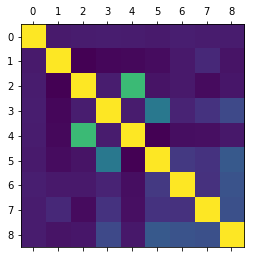

In [11]:
plt.matshow(train.corr())
plt.show()

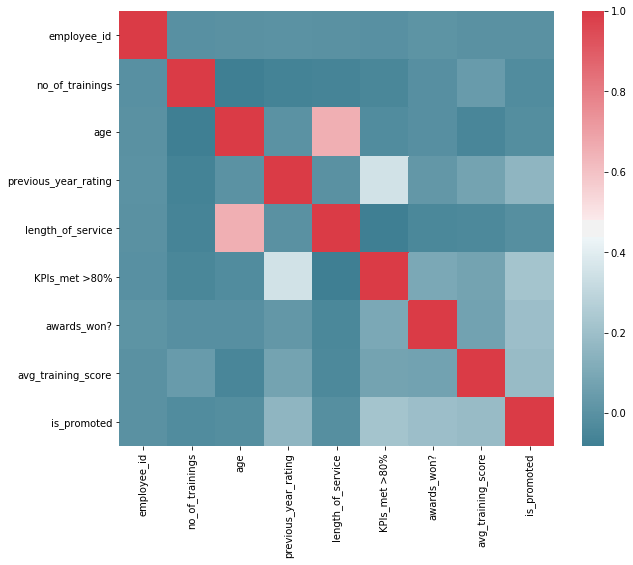

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr = train.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

> **NAN Imputation**

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


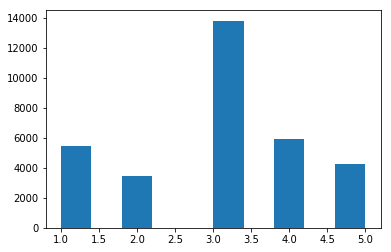

In [13]:
plt.hist(train[train['KPIs_met >80%'] == 0]['previous_year_rating'])
plt.show()

/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


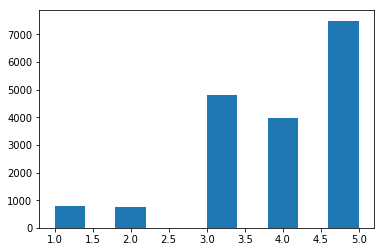

In [14]:
plt.hist(train[train['KPIs_met >80%'] == 1]['previous_year_rating'])
plt.show()

In [15]:
prev_rating_Three = train[(train['previous_year_rating'].isnull())][train['KPIs_met >80%'] == 0]['employee_id']

for empId in tqdm(prev_rating_Three):
    train.loc[train['employee_id']==empId,'previous_year_rating'] = 3.0
    
prev_rating_Three = test[(test['previous_year_rating'].isnull())][test['KPIs_met >80%'] == 0]['employee_id']

for empId in tqdm(prev_rating_Three):
    test.loc[test['employee_id']==empId,'previous_year_rating'] = 3.0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [16]:
prev_rating_Five = train[(train['previous_year_rating'].isnull())][train['KPIs_met >80%'] == 1]['employee_id']

for empId in tqdm(prev_rating_Five):
    train.loc[train['employee_id']==empId,'previous_year_rating'] = 5.0
    
prev_rating_Five = test[(test['previous_year_rating'].isnull())][test['KPIs_met >80%'] == 1]['employee_id']

for empId in tqdm(prev_rating_Five):
    test.loc[test['employee_id']==empId,'previous_year_rating'] = 5.0

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [17]:
train['education'] = train['education'].fillna('notGiven')
test['education'] = test['education'].fillna('notGiven')

In [18]:
X = train.drop(columns=['employee_id','is_promoted'])
y = train['is_promoted']
test.drop(columns=['employee_id'],inplace=True)

> **Feature Engineering**

In [19]:
X.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49
1,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60
2,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50
3,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50
4,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73


In [20]:
X['no_of_trainings'].unique()

array([ 1,  2,  3,  4,  7,  5,  6,  8, 10,  9])

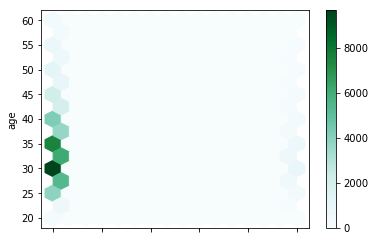

In [21]:
train.plot.hexbin('is_promoted','age',gridsize=15)

In [22]:
def binAge(x):
    age=''
    if (x<26):
        age='young'
    elif (x>=26 and x<=36):
        age='medium'
    else:
        age='old'
    return age

def binAgeTwo(x):
    age=''
    if (x<=30):
        age='young'
    else:
        age='medium'
    return age

In [23]:
X['age_bin_Two'] = X['age'].apply(binAgeTwo)
X['age_bin'] = X['age'].apply(binAge)

test['age_bin_Two'] = test['age'].apply(binAgeTwo)
test['age_bin'] = test['age'].apply(binAge)

In [24]:
X['frac_train'] = X['no_of_trainings']/10
test['frac_train'] = test['no_of_trainings']/10

In [25]:
X['crit_score'] = ((X['previous_year_rating']*X['KPIs_met >80%'] + X['previous_year_rating']*X['awards_won?'] + X['previous_year_rating']*X['frac_train'] ) * (20) + X['avg_training_score'])/400
test['crit_score'] = ((test['previous_year_rating']*test['KPIs_met >80%'] + test['previous_year_rating']*test['awards_won?'] + test['previous_year_rating']*test['frac_train'] ) * (20) + test['avg_training_score'])/400   

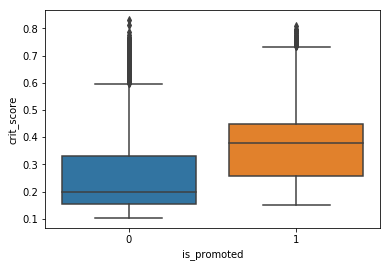

In [26]:
sns.boxplot(y,X['crit_score'])

> **Preparing Data for Training**

> **Data PreProcessing**

In [27]:
contVar = set(X.columns) - set(['previous_year_rating','department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','age_bin','age_bin_Two'])  
contVar = list(contVar)

In [28]:
flag = 1
iter = 0
while(flag!=0):
    iter = iter + 1
    if(iter > 20):
        break
    skewed_feats = X[contVar].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    #print("\nSkew in numerical features: \n")
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    print(skewness[np.abs(skewness['Skew'])>0.75])
    skewnessBox = skewness[(skewness.Skew)>0.75]
    skewnessSquare = skewness[(skewness.Skew)<-0.75]
    if(skewnessBox.shape[0] == 0 and skewnessSquare.shape[0] == 0):
        flag = 0
    #print("There are {} skewed numerical features to Box Cox transform".format(skewnessBox.shape[0]))
    #print("There are {} skewed numerical features to Square transform".format(skewnessSquare.shape[0]))
    skewed_features1 = skewnessBox.index
    skewed_features2 = skewnessSquare.index
    #print(skewed_features1)
    #print(skewed_features2)
    lam = 0.15
    for feat in skewed_features1:
        X[feat] = boxcox1p(X[feat], lam)
        test[feat] = boxcox1p(test[feat], lam)
    for feat in skewed_features2:
        X[feat] = np.square(X[feat])
        test[feat] = np.square(test[feat])

                       Skew
no_of_trainings    3.445340
frac_train         3.445340
length_of_service  1.738014
age                1.007404
crit_score         0.971139
                     Skew
frac_train       3.019191
no_of_trainings  2.395710
crit_score       0.849043
                     Skew
frac_train       2.764374
no_of_trainings  2.130215
crit_score       0.763189
                     Skew
frac_train       2.593183
no_of_trainings  2.014453
                     Skew
frac_train       2.469600
no_of_trainings  1.950965
                     Skew
frac_train       2.375947
no_of_trainings  1.911313
                     Skew
frac_train       2.302446
no_of_trainings  1.884374
                     Skew
frac_train       2.243208
no_of_trainings  1.864957
                     Skew
frac_train       2.194455
no_of_trainings  1.850339
                     Skew
frac_train       2.153644
no_of_trainings  1.838956
                     Skew
frac_train       2.118996
no_of_trainings  1.829855


In [29]:
X_dummies = X.copy()
X_dummies = pd.get_dummies(X,columns=['previous_year_rating','department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','age_bin','age_bin_Two'])    
test_dummies = pd.get_dummies(test,columns=['previous_year_rating','department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','age_bin','age_bin_Two'])    

In [30]:
Xstand = X_dummies.copy()
Xmin = X_dummies.copy()
Xrob = X_dummies.copy()

teststand = test_dummies.copy()
testmin = test_dummies.copy()
testrob = test_dummies.copy()

In [31]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler

standScl = StandardScaler()
minScl = MinMaxScaler()
robScl = RobustScaler()

Xstand[contVar] = standScl.fit_transform(X[contVar])
Xmin[contVar] = minScl.fit_transform(X[contVar])
Xrob[contVar] = robScl.fit_transform(X[contVar])

teststand[contVar] = standScl.transform(test[contVar])
testmin[contVar] = minScl.transform(test[contVar])
testrob[contVar] = robScl.transform(test[contVar])

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


In [32]:
def scoreOfModel(clf,X,y,flag,shuffleBool=False,nFolds=12):
    score = 0
    finalPreds = np.zeros(23490)
    #trainPreds = np.zeros(54808)
    folds = StratifiedKFold(n_splits=nFolds, shuffle=shuffleBool, random_state=42)
    train_pred = cross_val_predict(clf, X, y, cv=12,method='predict_proba')
    for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(X,y))):
        X_train,X_val = X.loc[trn_idx,:],X.loc[val_idx,:]
        #X_train,X_val = X[trn_idx],X[val_idx]
        y_train,y_val = y[trn_idx],y[val_idx]
        clf.fit(X_train,y_train)
        yPreds = clf.predict(X_val)
        score += f1_score(y_val,yPreds)
        if(flag==0):
            finalPreds += clf.predict(teststand)
        elif (flag==1):
            finalPreds += clf.predict(testmin)
        elif(flag==2):
            finalPreds += clf.predict(testrob)
        elif(flag==3):
            p = clf.predict_proba(test)
            #q = clf.predict_proba(X)    
            for k in range(len(p)):
                finalPreds[k] += p[k][0]
            #for l in range(len(q)):
            #    trainPreds[l] += q[l][0]
        print("**********"+ str(score/(1+fold_)) + "******************Iteration "+str(fold_)+" Done****************")    
    return str(score/nFolds),(train_pred),(finalPreds/nFolds)

def scoreOfModelTwo(clf,X,y,X_val,y_val):
    clf.fit(X,y)
    yPreds = clf.predict(X_val)
    score = f1_score(y_val,yPreds)
    finalPreds = clf.predict(test)
    return str(score),(finalPreds)


def scoreOfModelLGB(clfr,X,y,flag,shuffleBool=False,nFolds=12):
    score = 0
    finalPreds = np.zeros(23490)
    #trainPreds = np.zeros(54808)
    folds = StratifiedKFold(n_splits=nFolds, shuffle=shuffleBool, random_state=42)
    train_pred = cross_val_predict(clfr, X, y, cv=12,method='predict_proba')
    for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(X,y))):
        X_train,X_val = X.loc[trn_idx,:],X.loc[val_idx,:]
        #X_train,X_val = X[trn_idx],X[val_idx]
        y_train,y_val = y[trn_idx],y[val_idx]
        clf = clfr.fit(X_train,y_train)
        yPreds = clf.predict(X_val)
        score += f1_score(y_val,yPreds)
        if(flag==0):
            p = clf.predict_proba(teststand)
            #q = clf.predict_proba(X)    
            for k in range(len(p)):
                finalPreds[k] += p[k][0]
            #for l in range(len(q)):
            #    trainPreds[l] += q[l][0]
        elif (flag==1):
            p = clf.predict_proba(testmin)
            #q = clf.predict_proba(X)    
            for k in range(len(p)):
                finalPreds[k] += p[k][0]
            #for l in range(len(q)):
            #    trainPreds[l] += q[l][0]
        elif(flag==2):
            p = clf.predict_proba(testrob)
            #q = clf.predict_proba(X)    
            for k in range(len(p)):
                finalPreds[k] += p[k][0]
            #for l in range(len(q)):
            #    trainPreds[l] += q[l][0]
        elif(flag==3):
            p = clf.predict_proba(test)
            #q = clf.predict_proba(X)    
            for k in range(len(p)):
                finalPreds[k] += p[k][0]
            #for l in range(len(q)):
            #    trainPreds[l] += q[l][0]
        elif(flag==4):
            p = clf.predict_proba(test_dummies)
            #q = clf.predict_proba(X)    
            for k in range(len(p)):
                finalPreds[k] += p[k][0]
            #for l in range(len(q)):
            #    trainPreds[l] += q[l][0]
        print("**********"+ str(score/(1+fold_)) + "******************Iteration "+str(fold_)+" Done****************")    
    return str(score/nFolds),(train_pred),(finalPreds/nFolds)


In [33]:
catClf2 = CatBoostClassifier(learning_rate = 0.0353,iterations = 1500,eval_metric='F1',cat_features=['previous_year_rating','department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','age_bin','age_bin_Two'])    
clfDummies1 = lgb.LGBMClassifier(max_depth= 7, learning_rate=0.07532, n_estimators=402, num_leaves= 28, reg_alpha=2.154 , reg_lambda= 1.028)
clfDummies2 = lgb.LGBMClassifier(max_depth= 10, learning_rate=0.1, n_estimators=308, num_leaves= 30, reg_alpha=1.0 , reg_lambda= 0.1)
clfStand1 = lgb.LGBMClassifier(max_depth= 4, learning_rate=0.1, n_estimators=635, num_leaves= 30, reg_alpha=1.0 , reg_lambda= 0.1)
clfmin1 = lgb.LGBMClassifier(max_depth= 4, learning_rate=0.1, n_estimators=635, num_leaves= 30, reg_alpha=1.0 , reg_lambda= 0.1)

scr_clfDummies1,trainclfDummies1Preds,catclfDummies1Preds = scoreOfModelLGB(clfDummies1,X_dummies,y,4)
scr_clfDummies2,trainclfDummies2Preds,catclfDummies2Preds = scoreOfModelLGB(clfDummies2,X_dummies,y,4)
scr_clfStand1,trainclfStand1Preds,catclfStand1Preds = scoreOfModelLGB(clfStand1,Xstand,y,0)
scr_clfmin1,trainclfmin1Preds,catclfmin1Preds = scoreOfModelLGB(clfmin1,Xmin,y,1)
scr_catClf2,traincatClf2Preds,catClf2Preds = scoreOfModel(catClf2,X,y,3)

**********0.4801512287334594******************Iteration 0 Done****************
**********0.5106423419718485******************Iteration 1 Done****************
**********0.50804007423202******************Iteration 2 Done****************
**********0.5043945416553235******************Iteration 3 Done****************
**********0.4961710005558972******************Iteration 4 Done****************
**********0.49601551633626356******************Iteration 5 Done****************
**********0.5029368154025635******************Iteration 6 Done****************
**********0.5052466222295708******************Iteration 7 Done****************
**********0.5096769647974742******************Iteration 8 Done****************
**********0.5109314905399489******************Iteration 9 Done****************
**********0.5084658572008194******************Iteration 10 Done****************
**********0.507447085892731******************Iteration 11 Done****************



**********0.47817836812144215******************Iteration 0 Done****************
**********0.5051442299322807******************Iteration 1 Done****************
**********0.5056020502465981******************Iteration 2 Done****************
**********0.5023496858330967******************Iteration 3 Done****************
**********0.495909599412746******************Iteration 4 Done****************
**********0.49533820001187484******************Iteration 5 Done****************
**********0.5019350636512305******************Iteration 6 Done****************
**********0.5056138449014688******************Iteration 7 Done****************
**********0.5092325085992854******************Iteration 8 Done****************
**********0.511913693968562******************Iteration 9 Done****************
**********0.5098053403815362******************Iteration 10 Done****************
**********0.5091419802205902******************Iteration 11 Done****************



**********0.4801512287334594******************Iteration 0 Done****************
**********0.5091665234576388******************Iteration 1 Done****************
**********0.5114873597244474******************Iteration 2 Done****************
**********0.5060832914323778******************Iteration 3 Done****************
**********0.5003553549504136******************Iteration 4 Done****************
**********0.49919757294204264******************Iteration 5 Done****************
**********0.504588910655599******************Iteration 6 Done****************
**********0.505404185712538******************Iteration 7 Done****************
**********0.5104809306901392******************Iteration 8 Done****************
**********0.5119282165490366******************Iteration 9 Done****************
**********0.5099796783698467******************Iteration 10 Done****************
**********0.5082913406863782******************Iteration 11 Done****************



**********0.4708097928436912******************Iteration 0 Done****************
**********0.4991411601581094******************Iteration 1 Done****************
**********0.5029195035974697******************Iteration 2 Done****************
**********0.5001101452581762******************Iteration 3 Done****************
**********0.4961481537299931******************Iteration 4 Done****************
**********0.4961682375610639******************Iteration 5 Done****************
**********0.5022697525775277******************Iteration 6 Done****************
**********0.5036124275573814******************Iteration 7 Done****************
**********0.5081515589177127******************Iteration 8 Done****************
**********0.5091882548777933******************Iteration 9 Done****************
**********0.5080942044516078******************Iteration 10 Done****************
**********0.5065693472779194******************Iteration 11 Done****************

0:	learn: 0.1915469	total: 134ms	remaining: 3m 20

0:	learn: 0.1915469	total: 79ms	remaining: 1m 58s
1:	learn: 0.1915469	total: 117ms	remaining: 1m 27s
2:	learn: 0.1915469	total: 192ms	remaining: 1m 35s
3:	learn: 0.1760847	total: 266ms	remaining: 1m 39s
4:	learn: 0.1809363	total: 327ms	remaining: 1m 37s
5:	learn: 0.1703122	total: 363ms	remaining: 1m 30s
6:	learn: 0.1820097	total: 435ms	remaining: 1m 32s
7:	learn: 0.1871198	total: 470ms	remaining: 1m 27s
8:	learn: 0.1888610	total: 543ms	remaining: 1m 29s
9:	learn: 0.1890027	total: 589ms	remaining: 1m 27s
10:	learn: 0.1893417	total: 664ms	remaining: 1m 29s
11:	learn: 0.1911120	total: 740ms	remaining: 1m 31s
12:	learn: 0.1905558	total: 778ms	remaining: 1m 28s
13:	learn: 0.1900377	total: 854ms	remaining: 1m 30s
14:	learn: 0.1959064	total: 929ms	remaining: 1m 31s
15:	learn: 0.2012500	total: 997ms	remaining: 1m 32s
16:	learn: 0.2078838	total: 1.07s	remaining: 1m 33s
17:	learn: 0.2049470	total: 1.12s	remaining: 1m 32s
18:	learn: 0.2130741	total: 1.19s	remaining: 1m 32s
19:	learn: 0.2203913	to

In [34]:
stackedDF = pd.DataFrame({'dummiesOne' : trainclfDummies1Preds[:,0], 'dummiesTwo' : trainclfDummies2Preds[:,0],
                          'standOne' : trainclfStand1Preds[:,0], 'minOne' : trainclfmin1Preds[:,0],
                          'catClf' : traincatClf2Preds[:,0]
                         })

stackedTest = pd.DataFrame({'dummiesOne' : catclfDummies1Preds , 'dummiesTwo' : catclfDummies2Preds,
                          'standOne' : catclfStand1Preds, 'minOne' : catclfmin1Preds,
                          'catClf' : catClf2Preds
                         })

In [35]:
stackedDF.head()

,dummiesOne,dummiesTwo,standOne,minOne,catClf
0,0.751979,0.795099,0.753301,0.726677,0.748658
1,0.997605,0.998791,0.997217,0.996798,0.978664
2,0.999848,0.999964,0.999959,0.999940,0.999614
3,0.999918,0.999977,0.999974,0.999973,0.999226
4,0.997921,0.998190,0.994606,0.993715,0.993621


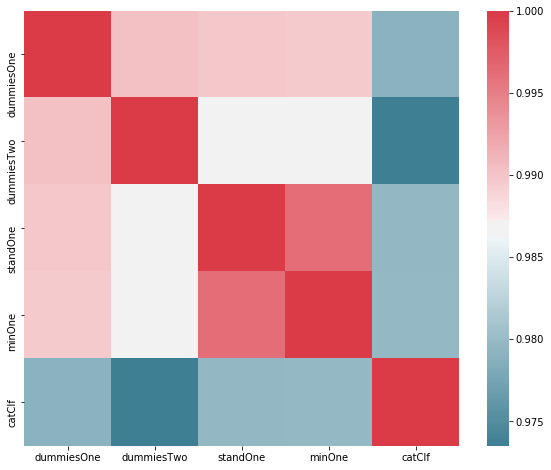

In [36]:
f, ax = plt.subplots(figsize=(10, 8))
corr = stackedDF.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [37]:
stackedTest.head()

,dummiesOne,dummiesTwo,standOne,minOne,catClf
0,0.782635,0.794427,0.759367,0.768025,0.834631
1,0.999692,0.999877,0.999859,0.999862,0.998464
2,0.999869,0.999930,0.999966,0.999960,0.999552
3,0.999447,0.999551,0.999797,0.999795,0.997783
4,0.998729,0.998441,0.998577,0.998499,0.997629


**PARAMETER TUNING**

In [38]:
# #bounds on different parameters 
# param_to_be_optimized = {'iterations':(600,1500),'learning_rate':(0.03,0.05),'depth':(3,10),
#                         'l2_leaf_reg':(2,21)}


# def param_handler_to_optimize(iterations,learning_rate,depth,l2_leaf_reg):
#     """
#     To handle integer type parameters:
    
#     """
#     thread_count=-1
#     iterations = int(iterations)
#     depth = int(depth) #int type params
#     #border_count = int(border_count)
#     #ctr_border_count = int(ctr_border_count)
    
#     param = {
#     'iterations': iterations,  # the maximum depth of each tree
#     'learning_rate': learning_rate,  # the training step for each iteration
#     'silent': True,  # logging mode - quiet
#     'depth':depth,
#     'l2_leaf_reg':l2_leaf_reg,
#     #'border_count':border_count,
#     #'thread_count':thread_count,
#     'task_type':'GPU',
#     'loss_function': 'CrossEntropy',  # error evaluation for multiclass training
#     'cat_features':['previous_year_rating','department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','age_bin','age_bin_Two']  
#     }
#     return func_to_be_optimized(param)

# def func_to_be_optimized(param):
    
#     model = CatBoostClassifier(**param)    
#     score = 0
#     #finalPreds=np.zeros(23490)
#     folds = StratifiedKFold(n_splits=12, shuffle=False, random_state=42)
#     for fold_, (trn_idx, val_idx) in tqdm(enumerate(folds.split(X,y))):
#         X_train,X_val = X.loc[trn_idx,:],X.loc[val_idx,:]
#         y_train,y_val = y[trn_idx],y[val_idx]
#         model.fit(X_train,y_train)
#         yPreds = model.predict(X_val)
#         score += f1_score(y_val,yPreds)
#     return (score/12)



# optimizer = BayesianOptimization(
#     f=param_handler_to_optimize,
#     pbounds=param_to_be_optimized,
#     random_state=1,
# )
# optimizer.maximize(
#     init_points=3,
#     n_iter=75,
# )
#------------------------------------------------------------------------------------------------
#bounds on different parameters 
# param_to_be_optimized = {'C':(0.001,20000)
#                         }

# def param_handler_to_optimize(C):
#     """
#     To handle integer type parameters:
    
#     """
   
#     param = {
#     'C':C,
#     #'max_depth':max_depth
#     #'C':C,
#     'solver':'liblinear'
#     }
#     return func_to_be_optimized(param)


# param_to_be_optimized = {'max_depth': (2, 15),'learning_rate': (0.001, 0.5),'n_estimators': (10, 1000), 
#                          'num_leaves': (2,50),'reg_alpha': (0.01, 10),'reg_lambda': (0, 3)}                                          

# def param_handler_to_optimize(max_depth,learning_rate,n_estimators,num_leaves,reg_alpha,reg_lambda):
#     """
#     To handle integer type parameters:
    
#     """
#     #thread_count=-1
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators) #int type params
#     num_leaves = int(num_leaves)  
#     #border_count = int(border_count)
#     #ctr_border_count = int(ctr_border_count)
    
#     param = {
#     'max_depth' : max_depth,  # the maximum depth of each tree
#     'learning_rate' : learning_rate,  # the training step for each iteration
#     'n_estimators' : n_estimators,  # logging mode - quiet
#     'num_leaves' : num_leaves,
#     'reg_alpha' : reg_alpha,
#     'reg_lamda' : reg_lambda,
#     #'border_count':border_count,
#     #'thread_count':thread_count,
# #     'task_type':'GPU',
# #     'loss_function': 'CrossEntropy',  # error evaluation for multiclass training
# #     'cat_features':['previous_year_rating','department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','age_bin','age_bin_Two']  
#     }
#     return func_to_be_optimized(param)

# def func_to_be_optimized(param):
    
#     #model = lgb.LGBMClassifier(**param)    
#     train_pred_opt = cross_val_predict(LogisticRegression(**param), stackedDFL2, y, cv=12,method='predict_proba')
#     train_pred_optTweaked = train_pred_opt[:,0]
#     thresholds = np.linspace(0.01, 0.99, 50)
#     mcc = np.array([f1_score(y, train_pred_optTweaked<thr) for thr in thresholds])
#     #best_threshold = thresholds[mcc.argmax()]
#     return (mcc.max())

# optimizer = BayesianOptimization(
#     f=param_handler_to_optimize,
#     pbounds=param_to_be_optimized,
#     random_state=1,
# )
# optimizer.maximize(
#     init_points=3,
#     n_iter=75,
# )

> **STACKING**

0.5344872803566746
0.75


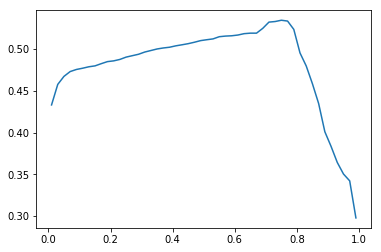

In [39]:
metaLearner = RandomForestClassifier(max_depth=5,n_estimators =116) 

metaLearner.fit(stackedDF,y)
padRF = metaLearner.predict_proba(stackedDF)
padRFTweaked = padRF[:,0]

thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([f1_score(y, padRFTweaked<thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())
print(best_threshold)

In [40]:
# metaLearner = LogisticRegression(solver='liblinear',C=1.931)
# metaLearner.fit(stackedDF,y)
# padLR = metaLearner.predict_proba(stackedDF)
# padLRtest = metaLearner.predict_proba(stackedTest)

# padLR = cross_val_predict(metaLearner, stackedDF, y, cv=12,method='predict_proba')
# padLRTweaked = padLR[:,0]

# thresholds = np.linspace(0.01, 0.99, 50)
# mcc = np.array([f1_score(y, padTweaked<thr) for thr in thresholds])
# plt.plot(thresholds, mcc)
# best_threshold = thresholds[mcc.argmax()]
# print(mcc.max())
# print(best_threshold)

# metaLearner = lgb.LGBMClassifier(learning_rate=0.07149459085784728,
#  max_depth= 4,
#  n_estimators= 10,
#  num_leaves= 49,
#  reg_alpha= 9.71326474211533,
#  reg_lambda= 0.36594150409622384) 

# metaLearner.fit(stackedDF,y)
# padLGBM = metaLearner.predict_proba(stackedDF)
# padLGBMtest = metaLearner.predict_proba(stackedTest)

# padLGBM = cross_val_predict(metaLearner, stackedDF, y, cv=12,method='predict_proba')

# padLGBMTweaked = padLGBM[:,0]

# thresholds = np.linspace(0.01, 0.99, 50)
# mcc = np.array([f1_score(y, padLGBMTweaked<thr) for thr in thresholds])
# plt.plot(thresholds, mcc)
# best_threshold = thresholds[mcc.argmax()]
# print(mcc.max())
# print(best_threshold)

# stackedDFL2 = pd.DataFrame({'padRF' : padRF[:,0], 'padLR' : padLR[:,0],
#                           'padLGBM' : padLGBM[:,0]
#                          })

# stackedTestL2 = pd.DataFrame({'padRF' : padRFtest[:,0] , 'padLR' : padLRtest[:,0],
#                           'padLGBM' : padLGBMtest[:,0]
#                          })

#metaLearner = LogisticRegression(solver='liblinear',C=optimizer.max['params']['C'])
# metaLearner = LogisticRegression(C=0.6064701322378264) 

# metaLearner.fit(stackedDFL2,y)
# padRF2 = metaLearner.predict_proba(stackedDFL2)
# padRF2Tweaked = padRF2[:,0]
# #padRF2 = cross_val_predict(metaLearner, stackedDFL2, y, cv=12,method='predict_proba')
# #padRF2Tweaked = padRF2[:,0]

# thresholds = np.linspace(0.01, 0.99, 50)
# mcc = np.array([f1_score(y, padRF2Tweaked<thr) for thr in thresholds])
# plt.plot(thresholds, mcc)
# best_threshold = thresholds[mcc.argmax()]
# print(mcc.max())
# print(best_threshold)

**Predictions**

In [41]:
sampleShuffle = pd.read_csv('../input/sample_submission_M0L0uXE.csv')

In [42]:
pad = metaLearner.predict_proba(stackedTest)
padTweaked = pad[:,0]

sampleShuffle['is_promoted'] = padTweaked<best_threshold
sampleShuffle['is_promoted'] = np.where(sampleShuffle['is_promoted']==False,0,1)

In [43]:
sampleShuffle.to_csv('submissionShuffle.csv',index=False)

In [44]:
from IPython.display import HTML
import pandas as pd
import numpy as np
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)
def create_download_link(df, title = "Download CSV file", filename = "submissionShuffle.csv"):  
    csv = df.to_csv(index=False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

# create a random sample dataframe
df = pd.DataFrame(np.random.randn(50, 4), columns=list('ABCD'))

# create a link to download the dataframe
create_download_link(sampleShuffle)